In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from spacy.lang.pl import Polish

import string 
import re

import seaborn as sns
from collections import  Counter
from matplotlib.pyplot import figure

In [ ]:
nlp = Polish()

### Data Loading

In [ ]:
!wget "http://2019.poleval.pl/task6/task_6-2.zip"

In [ ]:
!unzip "/content/task_6-2.zip" -d "/content/data"

In [ ]:
original_tags = pd.read_csv('/content/data/training_set_clean_only_tags.txt', header = None)
with open('/content/data/training_set_clean_only_text.txt', 'r') as textFile:
  lines = textFile.readlines()
original_text = pd.DataFrame(lines)

df = pd.concat([original_text,original_tags], axis=1)
df.columns =['Text', 'Tag']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10041 entries, 0 to 10040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    10041 non-null  object
 1   Tag     10041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.0+ KB


# Data Analysis

## Classes distribution

In [ ]:
df.Tag.value_counts()

0    9190
2     598
1     253
Name: Tag, dtype: int64

## Words Count

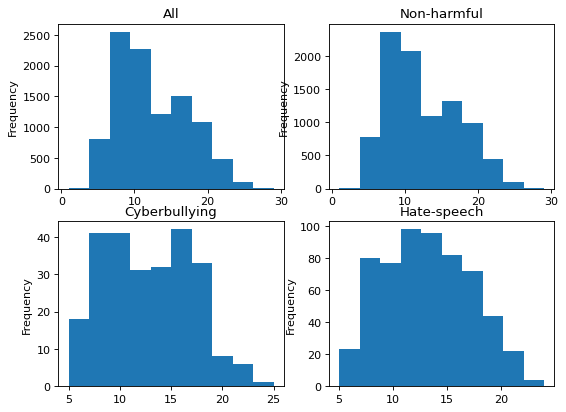

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.subplot(2,2,1)
df['Text'].apply(lambda x: len(x.split())).plot.hist(by=['Tag'], title = "All")
plt.subplot(2,2,2)
df[df.Tag == 0]['Text'].apply(lambda x: len(x.split())).plot.hist(by=['Tag'], title = "Non-harmful")
plt.subplot(2,2,3)
df[df.Tag == 1]['Text'].apply(lambda x: len(x.split())).plot.hist(by=['Tag'], title = "Cyberbullying")
plt.subplot(2,2,4)
df[df.Tag == 2]['Text'].apply(lambda x: len(x.split())).plot.hist(by=['Tag'], title = "Hate-speech")
plt.tight_layout()

## Length of text

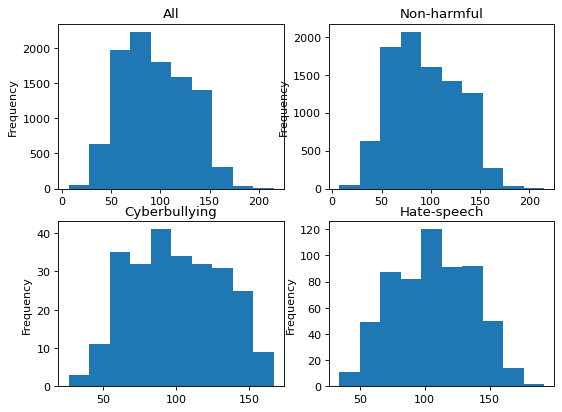

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.subplot(2,2,1)
df['Text'].str.len().plot.hist(title = "All")
plt.subplot(2,2,2)
df[df.Tag == 0]['Text'].str.len().plot.hist(title = "Non-harmful")
plt.subplot(2,2,3)
df[df.Tag == 1]['Text'].str.len().plot.hist(title = "Cyberbullying")
plt.subplot(2,2,4)
df[df.Tag == 2]['Text'].str.len().plot.hist(title = "Hate-speech")
plt.tight_layout()

## Average word length

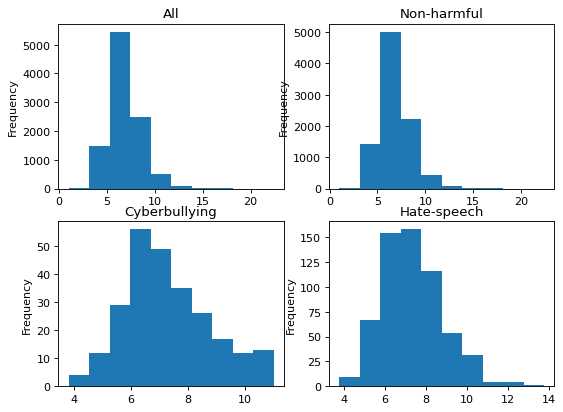

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.subplot(2,2,1)
df['Text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot.hist(title = "All")
plt.subplot(2,2,2)
df[df.Tag == 0]['Text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot.hist(title = "Non-harmful")
plt.subplot(2,2,3)
df[df.Tag == 1]['Text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot.hist(title = "Cyberbullying")
plt.subplot(2,2,4)
df[df.Tag == 2]['Text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).plot.hist(title = "Hate-speech")
plt.tight_layout()

## Stop words

In [ ]:
stopwords_count = []

for index, row in df.iterrows():
  for tok in nlp(row['Text']):
    if tok.is_stop:
      stopwords_count.append(tok.lower_)

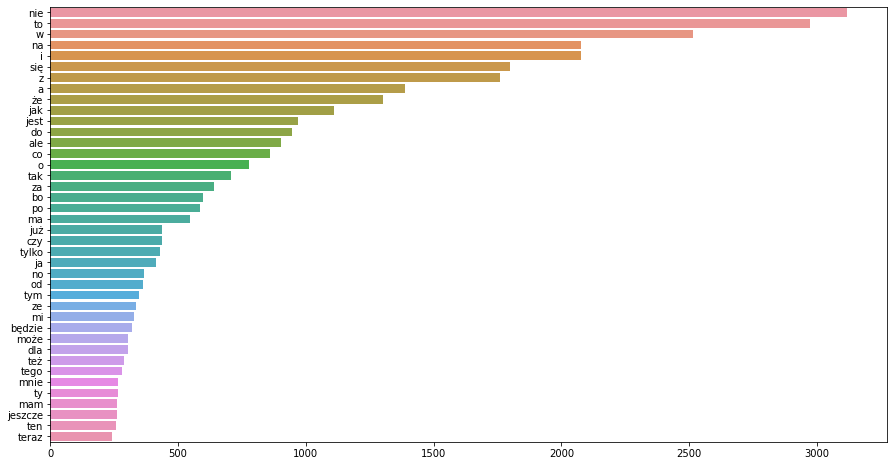

In [ ]:
counter=Counter(stopwords_count)
most=counter.most_common()

x, y=[], []
for word,count in most[:40]:
  x.append(word)
  y.append(count)

plt.figure(figsize=(15,8))         
sns.barplot(x=y,y=x)

## Non stop words

In [ ]:
nonstopwords_count = []

for index, row in df.iterrows():
  text = ' '.join(row['Text'].split())
  for tok in nlp(text):
    if not tok.is_stop and tok.text != "@anonymized_account" and tok.text != "RT" and tok.text not in string.punctuation:
      nonstopwords_count.append(tok.lower_)
        

In [ ]:
counter=Counter(nonstopwords_count)
most=counter.most_common()

x, y=[], []
for word,count in most[:40]:
  x.append(word)
  y.append(count)

plt.figure(figsize=(15,8))       
sns.barplot(x=y,y=x)

### For 1 and 2

In [ ]:
nonstopwords_count = []

for index, row in df[df.Tag != 0].iterrows():
  text = ' '.join(row['Text'].split())
  for tok in nlp(text):
    if not tok.is_stop and tok.text != "@anonymized_account" and tok.text != "RT" and tok.text not in string.punctuation:
      nonstopwords_count.append(tok.lower_)

In [ ]:
counter=Counter(nonstopwords_count)
most=counter.most_common()

x, y=[], []
for word,count in most[:40]:
  x.append(word)
  y.append(count)

plt.figure(figsize=(15,8))       
sns.barplot(x=y,y=x)

# Data Preprocessing

In [ ]:
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def preprocess_text(text):
  # remove whitespaces
  text = ' '.join(text.split())

  # tokenize
  doc = [tok for tok in nlp(text)]

  # remove RT @...
  if str(doc[0]) == "RT": 
    doc.pop(0)

  while str(doc[0]) == "@anonymized_account":
    doc.pop(0)
  while str(doc[-1]) == "@anonymized_account":
    doc.pop()

  # remove punctuation
  doc = [t for t in doc if t.text not in string.punctuation]
  
  # doc = [tok for tok in doc if not tok.is_stop]

  doc = [tok.lower_ for tok in doc]
  doc = [RE_EMOJI.sub(r'', str_text) for str_text in doc]

  return doc

In [ ]:
preprocess_text("RT @anonymized_account @anonymized_account Siemka, to ja :) @anonymized_account")

In [ ]:
df['Tokens'] = df['Text'].map(lambda x: preprocess_text(x))

In [ ]:
df[df["Tag"] == 1].head()

# Embedding

In [ ]:
!wget https://github.com/sdadas/polish-nlp-resources/releases/download/v1.0/word2vec.zip

In [ ]:
!unzip /content/word2vec.zip

Archive:  /content/word2vec.zip
replace word2vec_100_3_polish.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
word2vec = KeyedVectors.load("/content/word2vec_100_3_polish.bin")

In [ ]:
print(word2vec.most_similar(positive=['romantyk', 'kasyno']))